In [2]:
from model import get_bert_config
from transformers import AutoModelForSequenceClassification

In [61]:
from transformers.models.bert.modeling_bert import BertEmbeddings, BertEncoder,BertLayer, BertAttention, BertIntermediate, BertOutput

In [4]:
from modeling.bert import prepare_bert_for_quantization

ternary_bert = AutoModelForSequenceClassification.from_config(get_bert_config("base"))
prepare_bert_for_quantization(ternary_bert)

models = {
    "BERT\\textsubscript{BASE}": AutoModelForSequenceClassification.from_config(get_bert_config("base")),
    "BERT\\textsubscript{KD4}": AutoModelForSequenceClassification.from_config(get_bert_config("TinyBERT")),
    "BERT\\textsubscript{MEDIUM}": AutoModelForSequenceClassification.from_config(get_bert_config("medium")),
    "BERT\\textsubscript{SMALL}": AutoModelForSequenceClassification.from_config(get_bert_config("small")),
    "TernaryBERT": ternary_bert,
}

In [5]:
import torch
from modeling.quantization import QuantizedEmbedding, QuantizedLinear

def calculate_memory(module):
    if isinstance(module,QuantizedEmbedding):
        return module.weight.numel()*2/8+module.weight.shape[0]*32
    elif isinstance(module,QuantizedLinear):
        return module.weight.numel()*2/8+4+module.bias.numel()*4
    else:
        size = sum([p.element_size()*p.numel() for p in module.parameters(recurse=False)])
        for child_module in module.children():
            size += calculate_memory(child_module)
    #size_in_bytes = sum([p.element_size()*p.numel() for p in module.parameters()])
    return size

In [6]:
from contextlib import redirect_stderr
from fvcore.nn import FlopCountAnalysis
import io
f = io.StringIO()
with redirect_stderr(f):
    for name,model in models.items():
        num_params = sum([p.numel() for p in model.parameters()])
        if name not in ["TernaryBERT"]:
            flops = FlopCountAnalysis(model, 100*torch.ones((32,128)).long()).total()
        else:
            flops = 0
        print(f"{name}: {num_params/1e6:.1f}M, {calculate_memory(model)/1e6:.1f} MB, {flops/1e9:.1f} GFLOPs")

BERT\textsubscript{BASE}: 109.5M, 437.9 MB, 358.0 GFLOPs
BERT\textsubscript{KD4}: 14.4M, 57.4 MB, 20.0 GFLOPs
BERT\textsubscript{MEDIUM}: 41.4M, 165.5 MB, 107.6 GFLOPs
BERT\textsubscript{SMALL}: 28.8M, 115.1 MB, 53.8 GFLOPs
TernaryBERT: 109.5M, 30.3 MB, 0.0 GFLOPs


In [63]:
import time
import tqdm
import numpy as np

def time_model(model):
    input_batch = 100*torch.ones((32,128)).long()
    device = torch.device("cuda:2")
    input_batch = input_batch.to(device)
    model = model.to(device) 
    times = []
    with torch.no_grad():
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for i in tqdm.tqdm(range(50)):
            
            time.sleep(1)
            # start_time = time.time()
            # print(res.logits.sum())
            # times.append(time.time()-start_time)

            start.record()
            res = model(input_batch)
            x = res.logits.sum().item()
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()

            times.append(start.elapsed_time(end))
    
    print(f"{np.mean(times):.1f} ± {np.std(times):.1f} ms")
    return times, np.mean(times), np.std(times)

In [64]:
for name,model in models.items():
    print(name)
    times1,mean,std = time_model(model)
# times2,mean,std = time_model(models["BERT\\textsubscript{MEDIUM}"])
# times3,mean,std = time_model(models["BERT\\textsubscript{SMALL}"])

BERT\textsubscript{BASE}


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


178.1 ± 4.7 ms
BERT\textsubscript{KD4}


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


16.9 ± 0.9 ms
BERT\textsubscript{MEDIUM}


100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


53.6 ± 0.9 ms
BERT\textsubscript{SMALL}


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


27.2 ± 0.9 ms
TernaryBERT


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

370.9 ± 1.2 ms


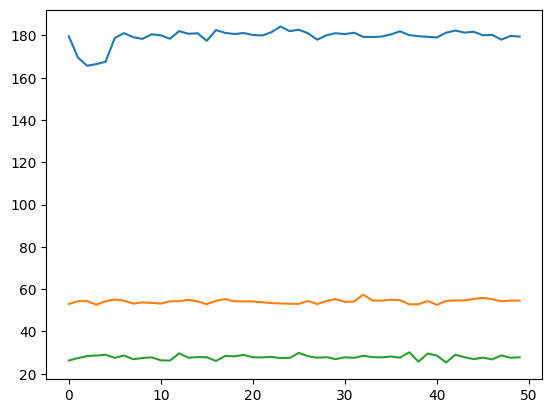

In [ ]:
import matplotlib.pyplot as plt
plt.plot(times1)
plt.plot(times2)
plt.plot(times3)

In [ ]:
long_times1 = times1
long_times2 = times2
long_times3 = times3
print(f"{np.mean(times1):.1f} ± {np.std(times1):.1f} ms")
print(np.mean(times2),np.std(times2))
print(np.mean(times3),np.std(times3))

179.4 ± 3.8 ms
54.1818660736084 0.9225729679291232
27.792589416503905 0.9957059817415368
